# Linear Regression

Unlike classification tasks where the interest was to classify the data according to a discrete set of classes (categories), in regression we are interested to get a continous value out of our model. For instance, we might want to estimate the price of a house based on some features such as number of rooms, area of the house etc. Linear regression can be considered the simplest form of regression and it is given by the following function:

$y(x,w)=w_0 \cdot x_0+w_1\cdot x_1+w_2\cdot x_2+\dotsc+w_n\cdot x_n$

The key property of this model is that it is a linear function of the parameters $w_0,w_1, w_2, \dotsc, w_n$. It is also, however, a linear function of the input variables $x_i$, and this imposes significant limitations on the model. In the following tutorial we will investigate using a linear regressor of a single variable $x$ to predict the house prices using the well-known Boston house prices dataset. In fact, in this dataset many features are contributing to the house prices, but for simplicity we will choose one variable at time and investigate how the slope and the intercept are changing in order to minimise the cost.

Please refer to your lecture notes for more information on Linear regression.

In [ ]:
# import the necessary packages
import numpy as np # matrix operations
import pandas as pd # dataframes
import seaborn as sns 
import matplotlib.pyplot as plt # plots
from sklearn.datasets import load_boston # dataset
import warnings # ignore package warnings
warnings.filterwarnings('ignore')

In [ ]:
# load the data and print description about them
boston = load_boston()
print(boston['DESCR'])

.. _boston_dataset:

Boston house prices dataset
---------------------------

**Data Set Characteristics:**  

    :Number of Instances: 506 

    :Number of Attributes: 13 numeric/categorical predictive. Median Value (attribute 14) is usually the target.

    :Attribute Information (in order):
        - CRIM     per capita crime rate by town
        - ZN       proportion of residential land zoned for lots over 25,000 sq.ft.
        - INDUS    proportion of non-retail business acres per town
        - CHAS     Charles River dummy variable (= 1 if tract bounds river; 0 otherwise)
        - NOX      nitric oxides concentration (parts per 10 million)
        - RM       average number of rooms per dwelling
        - AGE      proportion of owner-occupied units built prior to 1940
        - DIS      weighted distances to five Boston employment centres
        - RAD      index of accessibility to radial highways
        - TAX      full-value property-tax rate per $10,000
        - PTRATIO  pu

In [ ]:
# print feature names used in the data
boston.feature_names

array(['CRIM', 'ZN', 'INDUS', 'CHAS', 'NOX', 'RM', 'AGE', 'DIS', 'RAD',
       'TAX', 'PTRATIO', 'B', 'LSTAT'], dtype='<U7')

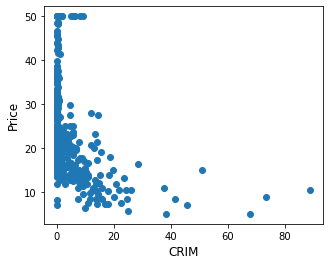

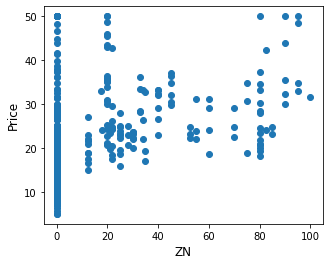

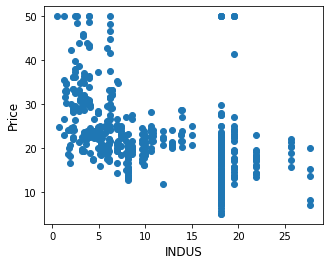

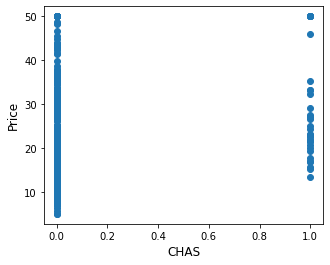

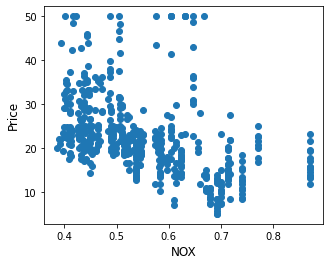

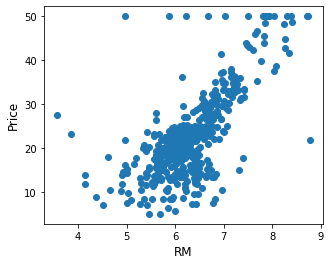

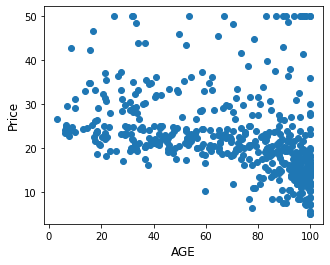

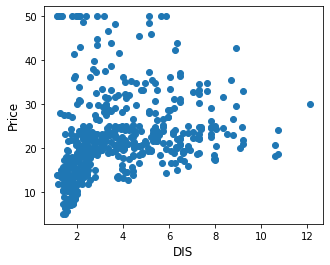

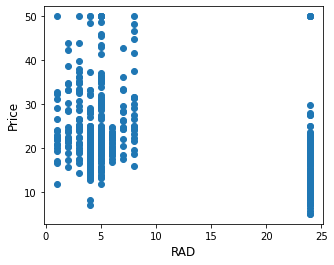

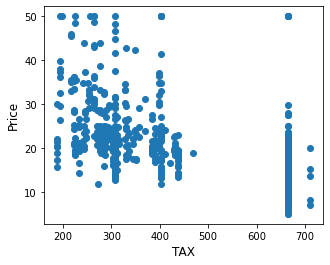

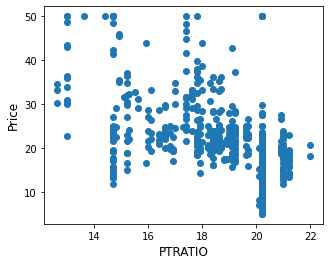

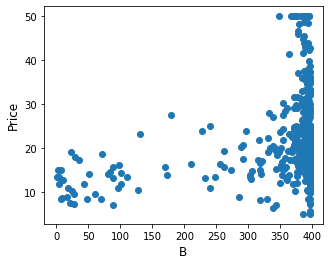

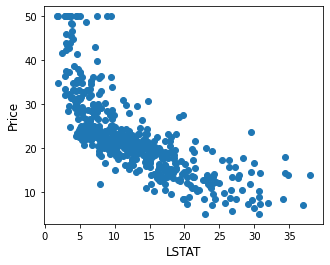

CRIM    ZN  INDUS  CHAS    NOX     RM   AGE     DIS  RAD    TAX  \
0    0.00632  18.0   2.31   0.0  0.538  6.575  65.2  4.0900  1.0  296.0   
1    0.02731   0.0   7.07   0.0  0.469  6.421  78.9  4.9671  2.0  242.0   
2    0.02729   0.0   7.07   0.0  0.469  7.185  61.1  4.9671  2.0  242.0   
3    0.03237   0.0   2.18   0.0  0.458  6.998  45.8  6.0622  3.0  222.0   
4    0.06905   0.0   2.18   0.0  0.458  7.147  54.2  6.0622  3.0  222.0   
..       ...   ...    ...   ...    ...    ...   ...     ...  ...    ...   
501  0.06263   0.0  11.93   0.0  0.573  6.593  69.1  2.4786  1.0  273.0   
502  0.04527   0.0  11.93   0.0  0.573  6.120  76.7  2.2875  1.0  273.0   
503  0.06076   0.0  11.93   0.0  0.573  6.976  91.0  2.1675  1.0  273.0   
504  0.10959   0.0  11.93   0.0  0.573  6.794  89.3  2.3889  1.0  273.0   
505  0.04741   0.0  11.93   0.0  0.573  6.030  80.8  2.5050  1.0  273.0   

     PTRATIO       B  LSTAT  MEDV  
0       15.3  396.90   4.98  24.0  
1       17.8  396.90   9.14  21.6  
2       17.8  392.83   4.03  34.7  
3       18.7  394.63   2.94  33.4  
4       18.7  396.90   5.33  36.2  
..       ...     ...    ...   ...  
501     21.0  391.99   9.67  22.4  
502     21.0  396.90   9.08  20.6  
503     21.0  396.90   5.64  23.9  
504     21.0  393.45   6.48  22.0  
505     21.0  396.90   7.88  11.9  

[506 rows x 14 columns]

In [ ]:
# the following code shows the relation between house prices (output) and each feature used.

for index, feature_name in enumerate(boston.feature_names):
    plt.figure(figsize=(5, 4))
    plt.scatter(boston.data[:, index], boston.target)
    plt.ylabel('Price', size=12)
    plt.xlabel(feature_name, size=12)
    plt.show()
    
boston_data = pd.DataFrame(data=boston['data'],columns=boston['feature_names'])
boston_data["MEDV"] = boston['target']
boston_data

We will attempt the linear regression problem using Gradient Descent (GD) method and you will need to compare the results with the closed form solution as specified in Task 1.

In [ ]:
# function to perform the prediction by multiplying the inputs with weights
def predictPrice(X,W):
    return np.dot(X,W)

In [ ]:
# function to calculate the cost (here we use MSE)
def calculateCost(X,W,Y):
    prediction = predictPrice(X,W)
    return ((Y - prediction)**2).mean()/2

In [ ]:
# function to plot the predicted line vs real data
def plot_line(X,W,Y):
    """Plot a line from slope and intercept"""
    y_vals = predictPrice(X,W)
    plt.xlabel('Number of Rooms in the house (RM)')
    plt.ylabel('Price of house (MEDV)')
    plt.scatter(X[:,1],Y, color='red', label='Actual')
    plt.plot(X[:,1], y_vals, color='black', label='Predicted')
    plt.legend(loc='upper left')
    plt.show()

In [ ]:
# function to plot cost variations as the algorithm iterate 
def plot_cost(cost):
    plt.plot(range(1, len(cost) + 1), cost)
    plt.xlabel('Iterations')
    plt.ylabel('Cost')
    plt.show()

In [ ]:
# function that applies GD and fit the algorithm
def fit(n_iter,X,Y):
    W0 = []
    W1 = []
    costs = []
    N = len(boston['target'])
    W = np.zeros(2)
    c = 0
    for i in range(n_iter):
        pred = predictPrice(X,W)
        W[0] += (2/N) *(Y - pred).mean()
        W[1] += (2/N) *((Y - pred)* X[:,1]).mean()
        W = np.array([W[0],W[1]])
        J = calculateCost(X,W,Y)
        W0.append(W[0])
        W1.append(W[1])
        costs.append(J)
        c = i + 1
        if i%1000==0:
            print(f"Iteration: {i}, Cost = {J}, Weights = {W}")
            plot_line(X,W,Y)
    print(f"Iteration: {c}, Cost = {J}, Weights = {W}")
    plot_line(X,W,Y)
    plot_cost(costs)

Iteration: 0, Cost = 216.6983542187835, Weights = [0.08906248 0.57745065]


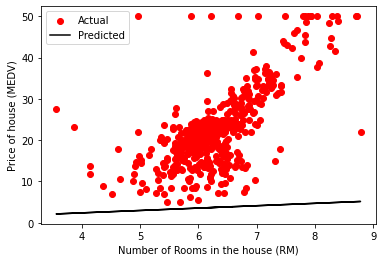

Iteration: 1000, Cost = 28.75263639621522, Weights = [-1.07656592  3.82095325]


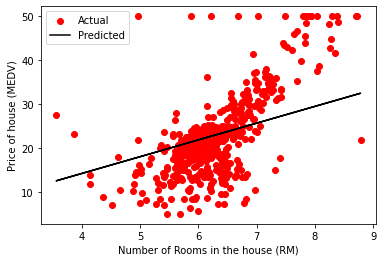

Iteration: 2000, Cost = 28.122244565209886, Weights = [-2.63578846  4.06607093]


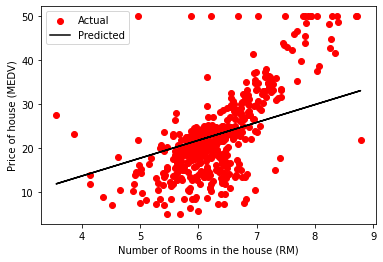

Iteration: 3000, Cost = 27.54901229317604, Weights = [-4.12264181  4.29981182]


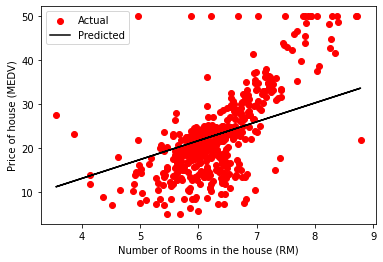

Iteration: 4000, Cost = 27.02775674775269, Weights = [-5.54048487  4.52270394]


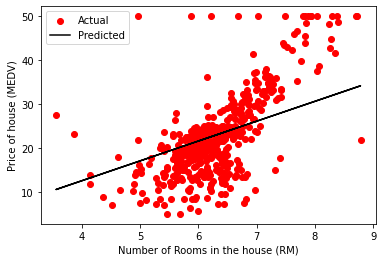

Iteration: 5000, Cost = 26.55376503987033, Weights = [-6.89252067  4.73525082]


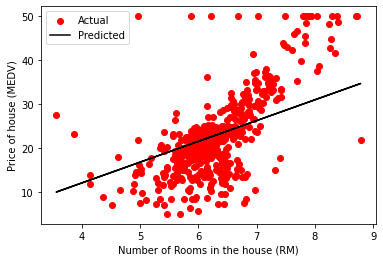

Iteration: 6000, Cost = 26.122751612552776, Weights = [-8.18180355  4.93793262]


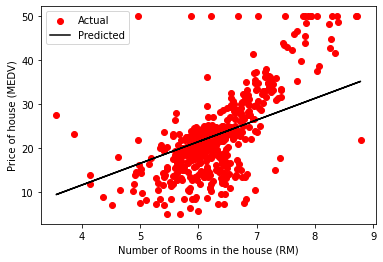

Iteration: 7000, Cost = 25.730819493406617, Weights = [-9.41124612  5.13120723]


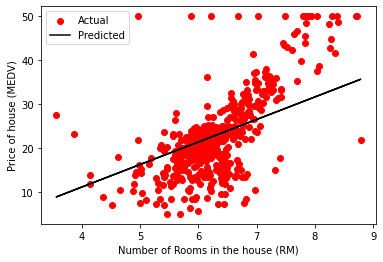

Iteration: 8000, Cost = 25.37442506046656, Weights = [-10.58362578   5.31551125]


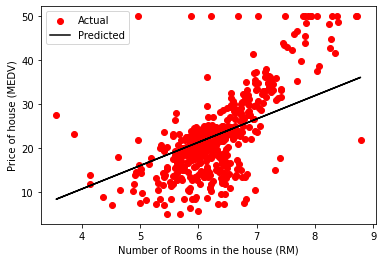

Iteration: 9000, Cost = 25.050346002829254, Weights = [-11.70159102   5.49126106]


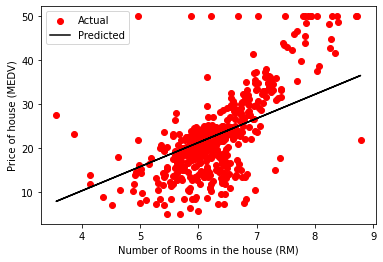

Iteration: 10000, Cost = 24.755652186394837, Weights = [-12.76766742   5.65885367]


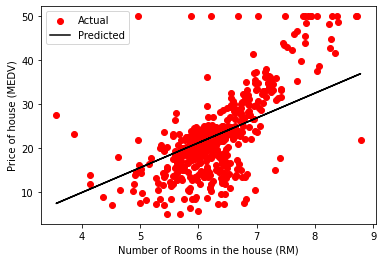

Iteration: 11000, Cost = 24.487679161300893, Weights = [-13.78426333   5.8186677 ]


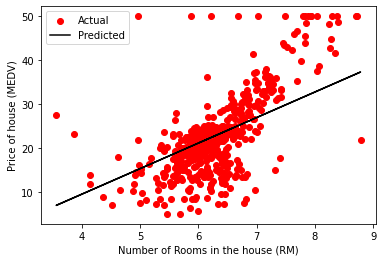

Iteration: 12000, Cost = 24.244004071518354, Weights = [-14.75367532   5.97106418]


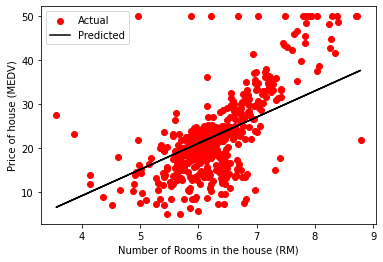

Iteration: 13000, Cost = 24.02242374879853, Weights = [-15.67809336   6.11638739]


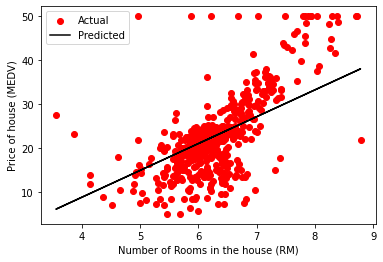

Iteration: 14000, Cost = 23.820934792908805, Weights = [-16.55960579   6.25496561]


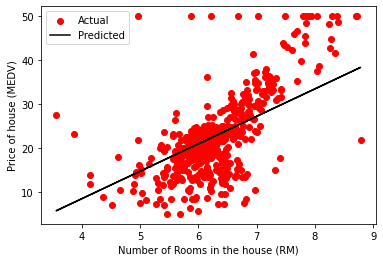

Iteration: 15000, Cost = 23.637715458054473, Weights = [-17.40020402   6.38711191]


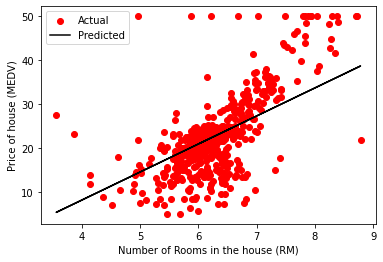

Iteration: 16000, Cost = 23.471109181714265, Weights = [-18.20178702   6.51312482]


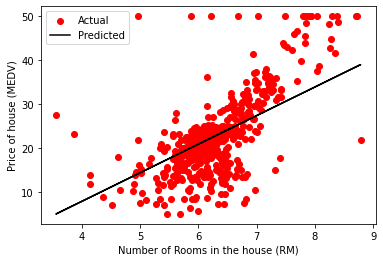

Iteration: 17000, Cost = 23.319609606966797, Weights = [-18.96616563   6.63328902]


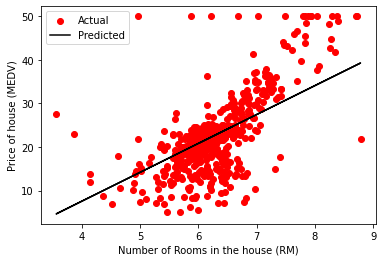

Iteration: 18000, Cost = 23.181846962888457, Weights = [-19.69506664   6.74787595]


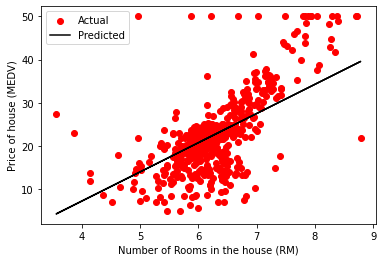

Iteration: 19000, Cost = 23.056575679882688, Weights = [-20.3901367    6.85714449]


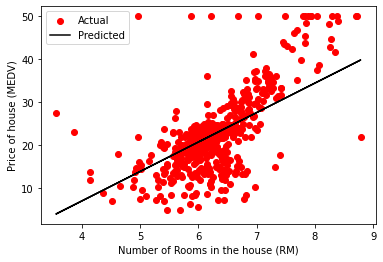

Iteration: 20000, Cost = 22.942663127964785, Weights = [-21.05294602   6.96134147]


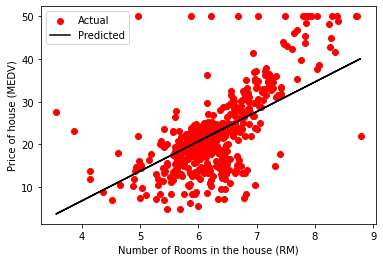

Iteration: 21000, Cost = 22.83907937618151, Weights = [-21.68499195   7.0607023 ]


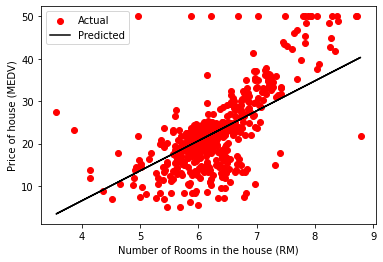

Iteration: 22000, Cost = 22.744887880574968, Weights = [-22.28770232   7.15545142]


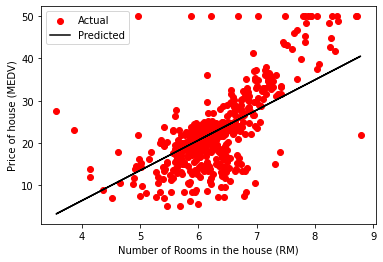

Iteration: 23000, Cost = 22.659237016497794, Weights = [-22.8624387   7.2458029]


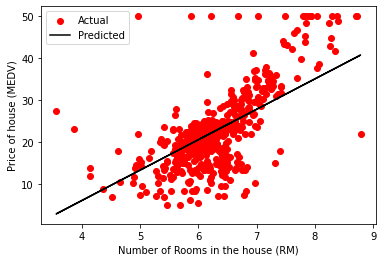

Iteration: 24000, Cost = 22.581352378718904, Weights = [-23.41049948   7.33196083]


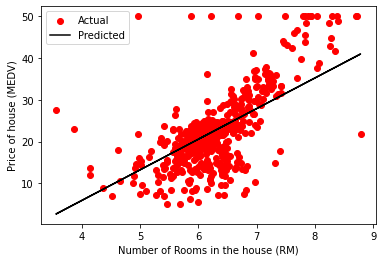

Iteration: 25000, Cost = 22.510529779702484, Weights = [-23.93312276   7.41411986]


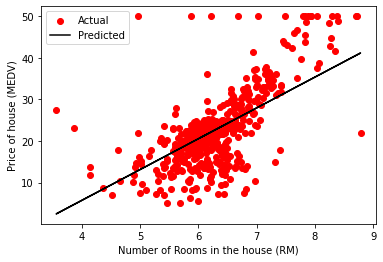

Iteration: 26000, Cost = 22.446128882754344, Weights = [-24.43148918   7.49246559]


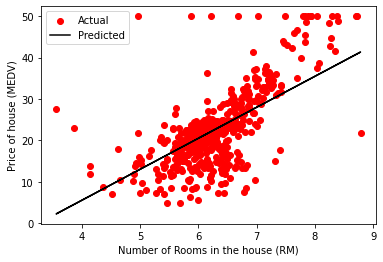

Iteration: 27000, Cost = 22.38756741247045, Weights = [-24.9067246   7.567175 ]


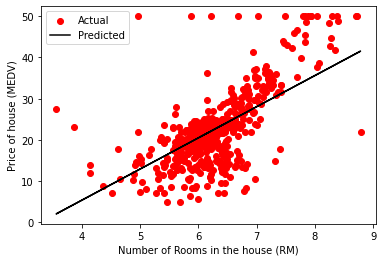

Iteration: 28000, Cost = 22.334315890142005, Weights = [-25.35990262   7.63841688]


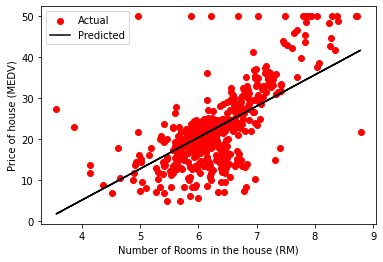

Iteration: 29000, Cost = 22.285892846517026, Weights = [-25.79204699   7.70635217]


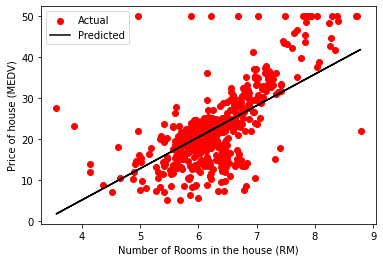

Iteration: 30000, Cost = 22.24186046863596, Weights = [-26.20413396   7.77113433]


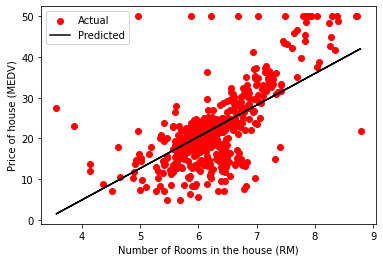

Iteration: 31000, Cost = 22.20182064138193, Weights = [-26.59709448   7.83290972]


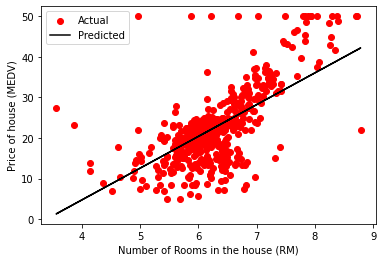

Iteration: 32000, Cost = 22.165411347955533, Weights = [-26.97181626   7.89181788]


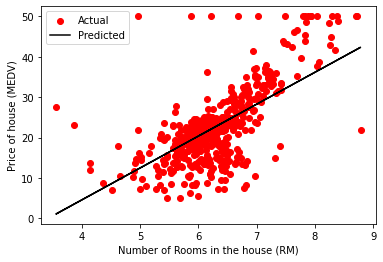

Iteration: 33000, Cost = 22.13230339672993, Weights = [-27.32914585   7.9479919 ]


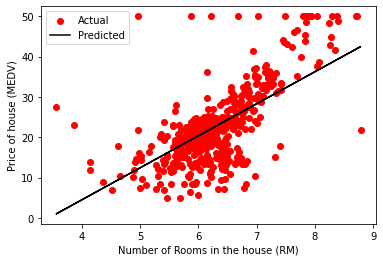

Iteration: 34000, Cost = 22.10219744489172, Weights = [-27.66989046   8.00155868]


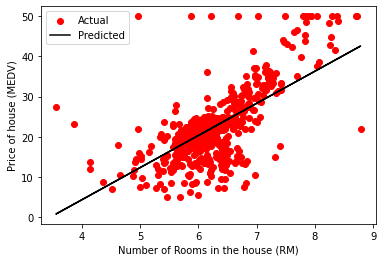

Iteration: 35000, Cost = 22.07482129195769, Weights = [-27.99481987   8.05263924]


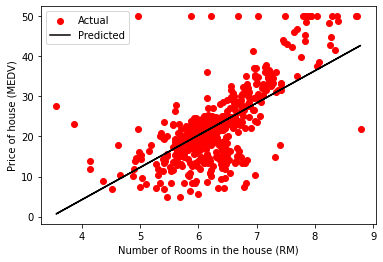

Iteration: 36000, Cost = 22.049927418696534, Weights = [-28.30466813   8.10134895]


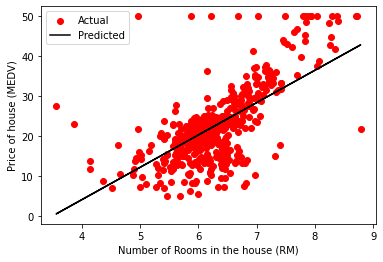

Iteration: 37000, Cost = 22.027290749204084, Weights = [-28.6001352    8.14779787]


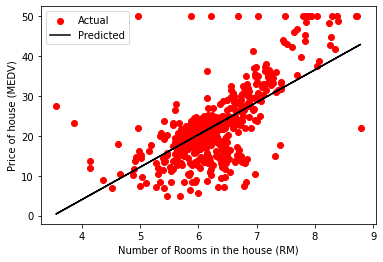

Iteration: 38000, Cost = 22.00670661589804, Weights = [-28.88188856   8.19209093]


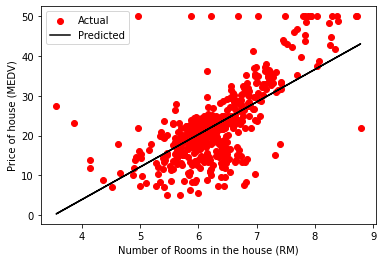

Iteration: 39000, Cost = 21.987988909033014, Weights = [-29.15056473   8.23432819]


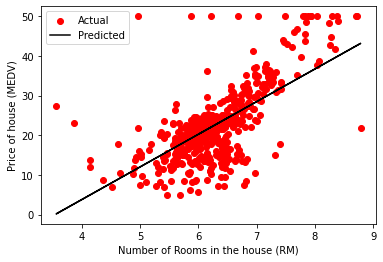

Iteration: 40000, Cost = 21.970968394004462, Weights = [-29.40677065   8.27460506]


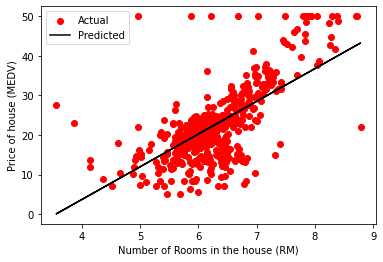

Iteration: 41000, Cost = 21.955491181228037, Weights = [-29.65108512   8.31301253]


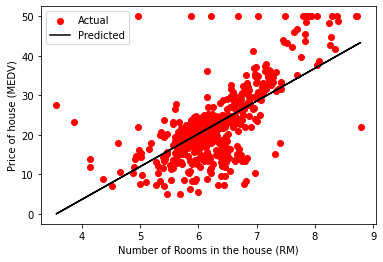

Iteration: 42000, Cost = 21.94141733475945, Weights = [-29.88406007   8.34963737]


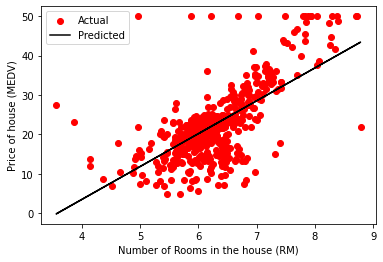

Iteration: 43000, Cost = 21.928619607075497, Weights = [-30.1062218    8.38456232]


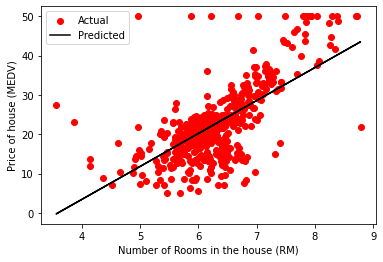

Iteration: 44000, Cost = 21.916982288575547, Weights = [-30.3180722    8.41786628]


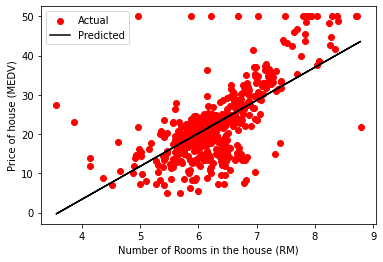

Iteration: 45000, Cost = 21.90640016140322, Weights = [-30.52008984   8.44962448]


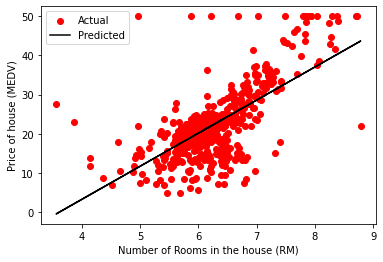

Iteration: 46000, Cost = 21.896777548127464, Weights = [-30.71273111   8.47990866]


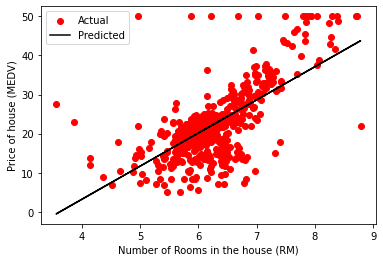

Iteration: 47000, Cost = 21.888027446683164, Weights = [-30.8964312    8.50878725]


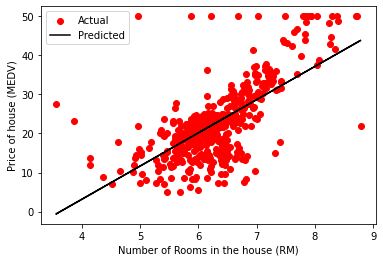

Iteration: 48000, Cost = 21.880070743749016, Weights = [-31.0716051    8.53632547]


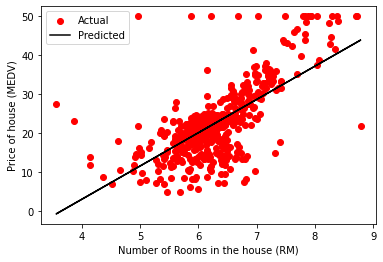

Iteration: 49000, Cost = 21.87283549945088, Weights = [-31.23864854   8.56258555]


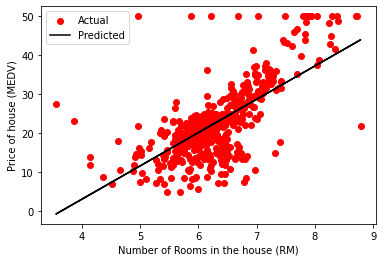

Iteration: 50000, Cost = 21.86625629692361, Weights = [-31.39793888   8.5876268 ]


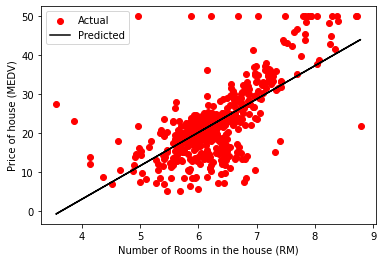

Iteration: 51000, Cost = 21.86027365084954, Weights = [-31.54983597   8.61150579]


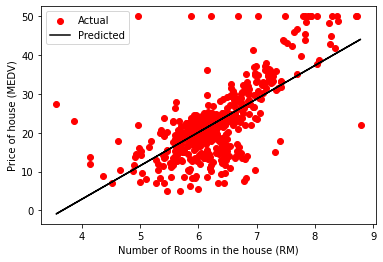

Iteration: 52000, Cost = 21.85483346962711, Weights = [-31.69468297   8.63427647]


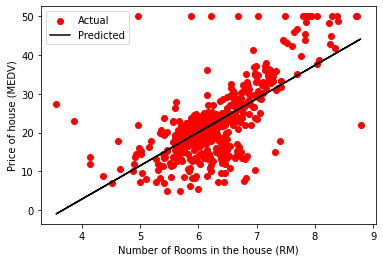

Iteration: 53000, Cost = 21.849886566305997, Weights = [-31.8328071    8.65599028]


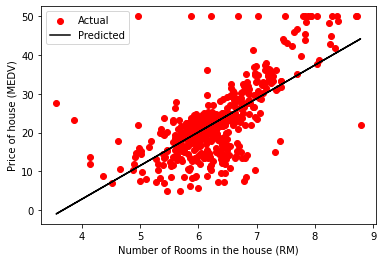

Iteration: 54000, Cost = 21.845388213867363, Weights = [-31.96452037   8.67669628]


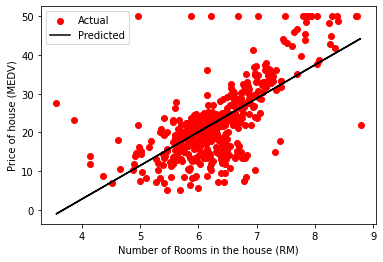

Iteration: 55000, Cost = 21.841297740828246, Weights = [-32.09012036   8.69644123]


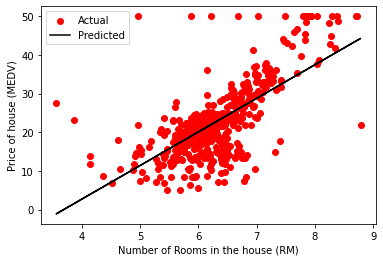

Iteration: 56000, Cost = 21.83757816351367, Weights = [-32.20989079   8.71526975]


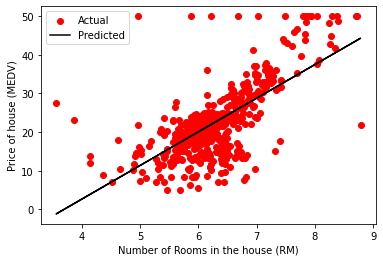

Iteration: 57000, Cost = 21.834195851671762, Weights = [-32.32410224   8.73322437]


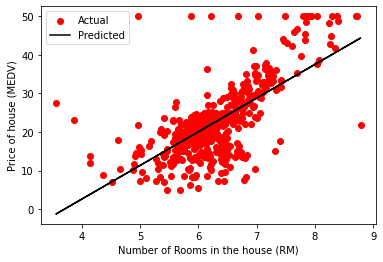

Iteration: 58000, Cost = 21.831120224408675, Weights = [-32.43301272   8.75034565]


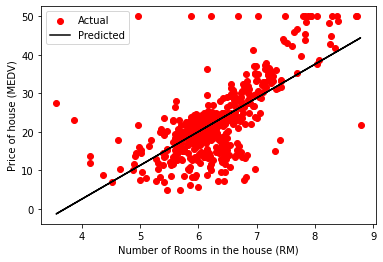

Iteration: 59000, Cost = 21.828323473693924, Weights = [-32.53686826   8.76667227]


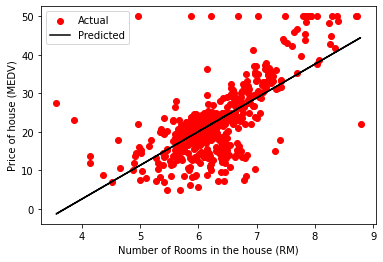

Iteration: 60000, Cost = 21.825780312936303, Weights = [-32.6359035    8.78224111]


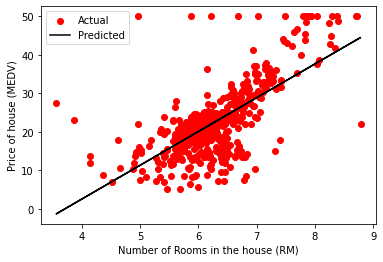

Iteration: 61000, Cost = 21.82346774835737, Weights = [-32.73034214   8.79708734]


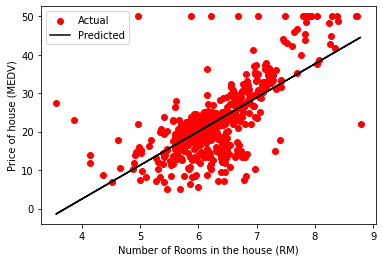

Iteration: 62000, Cost = 21.82136487109503, Weights = [-32.82039755   8.81124451]


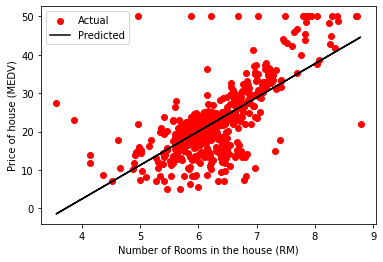

Iteration: 63000, Cost = 21.81945266815768, Weights = [-32.90627315   8.82474459]


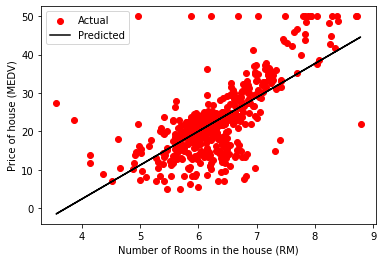

Iteration: 64000, Cost = 21.81771385052006, Weights = [-32.98816296   8.83761808]


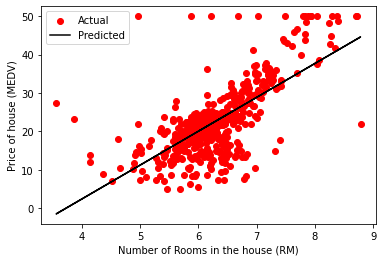

Iteration: 65000, Cost = 21.816132696805756, Weights = [-33.06625196   8.84989407]


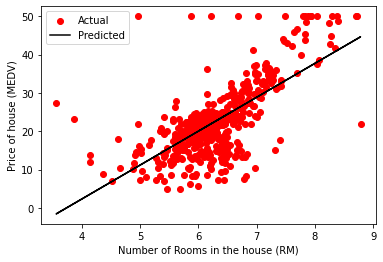

Iteration: 66000, Cost = 21.81469491114372, Weights = [-33.14071656   8.86160028]


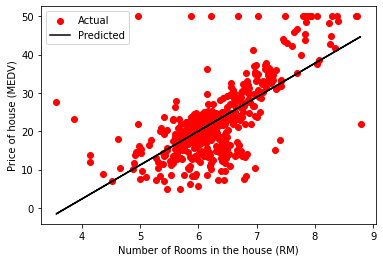

Iteration: 67000, Cost = 21.813387493913307, Weights = [-33.21172499   8.87276317]


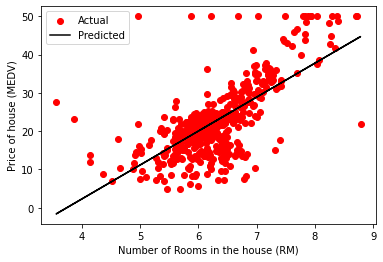

Iteration: 68000, Cost = 21.812198624209437, Weights = [-33.27943767   8.88340794]


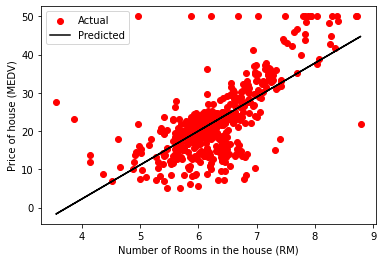

Iteration: 69000, Cost = 21.81111755296453, Weights = [-33.34400754   8.89355866]


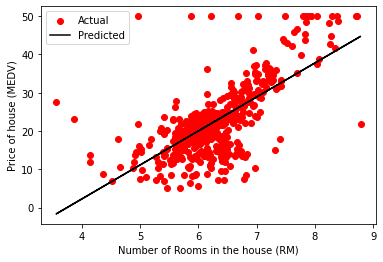

Iteration: 70000, Cost = 21.810134505762075, Weights = [-33.4055805    8.90323824]


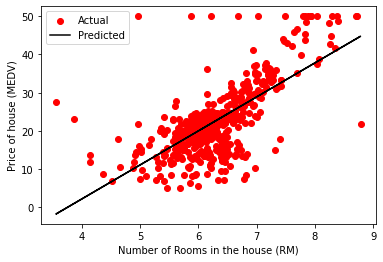

Iteration: 71000, Cost = 21.809240594461684, Weights = [-33.46429563   8.91246855]


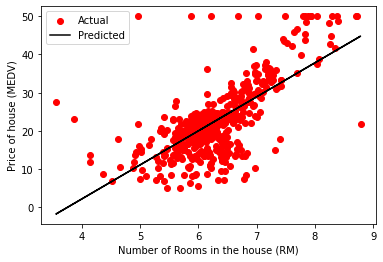

Iteration: 72000, Cost = 21.808427736838027, Weights = [-33.52028558   8.92127046]


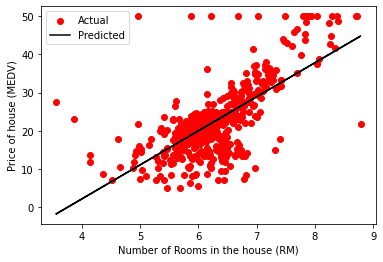

Iteration: 73000, Cost = 21.80768858350592, Weights = [-33.57367683   8.92966383]


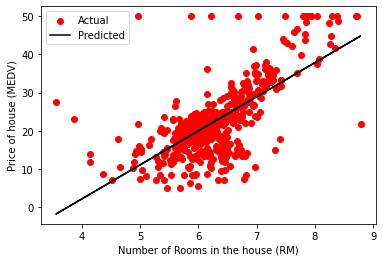

Iteration: 74000, Cost = 21.80701645147133, Weights = [-33.62459      8.93766764]


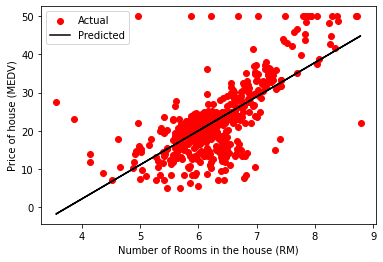

Iteration: 75000, Cost = 21.806405263707873, Weights = [-33.6731401    8.94529996]


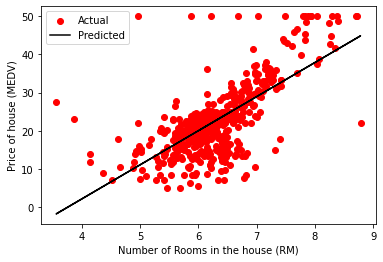

Iteration: 76000, Cost = 21.80584949421172, Weights = [-33.71943681   8.95257804]


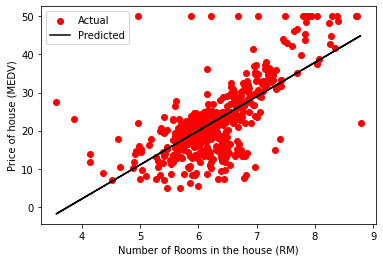

Iteration: 77000, Cost = 21.805344118038807, Weights = [-33.76358473   8.95951832]


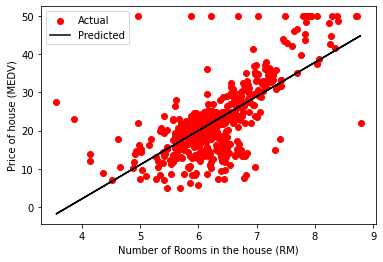

Iteration: 78000, Cost = 21.80488456587206, Weights = [-33.80568358   8.96613647]


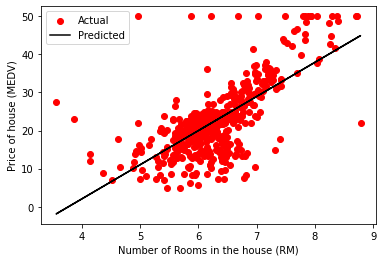

Iteration: 79000, Cost = 21.804466682708444, Weights = [-33.84582847   8.97244745]


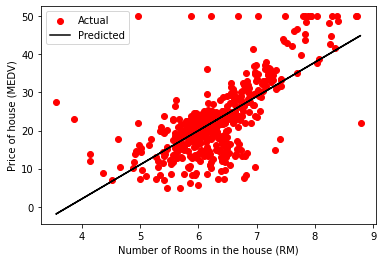

Iteration: 80000, Cost = 21.804086690291758, Weights = [-33.88411008   8.97846551]


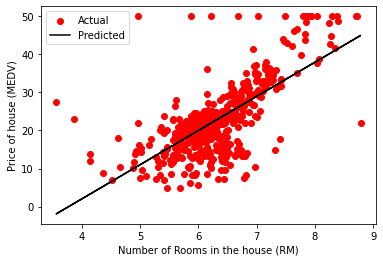

Iteration: 81000, Cost = 21.80374115295187, Weights = [-33.92061491   8.98420426]


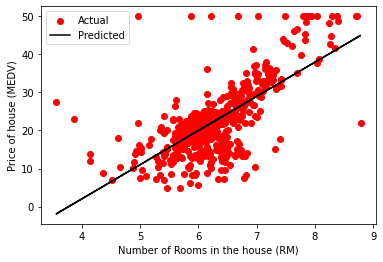

Iteration: 82000, Cost = 21.803426946541347, Weights = [-33.95542542   8.98967664]


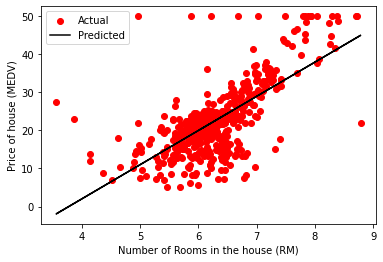

Iteration: 83000, Cost = 21.80314123018894, Weights = [-33.98862024   8.99489504]


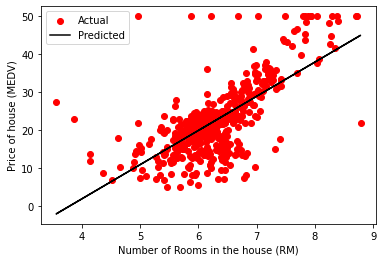

Iteration: 84000, Cost = 21.802881420613645, Weights = [-34.02027437   8.99987123]


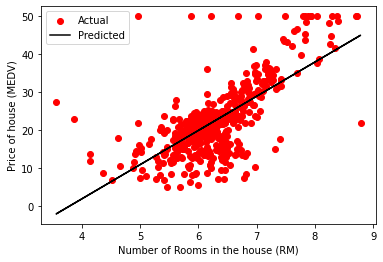

Iteration: 85000, Cost = 21.80264516876866, Weights = [-34.05045932   9.00461646]


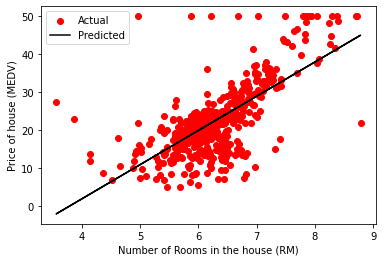

Iteration: 86000, Cost = 21.802430338602402, Weights = [-34.07924327   9.00914144]


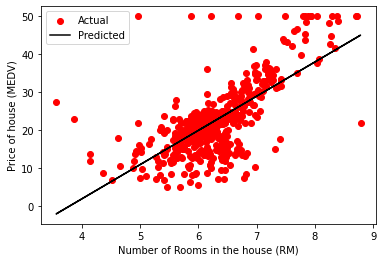

Iteration: 87000, Cost = 21.80223498774559, Weights = [-34.10669126   9.0134564 ]


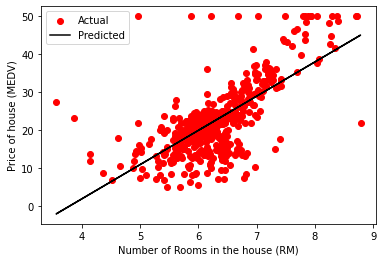

Iteration: 88000, Cost = 21.80205734994956, Weights = [-34.13286528   9.01757109]


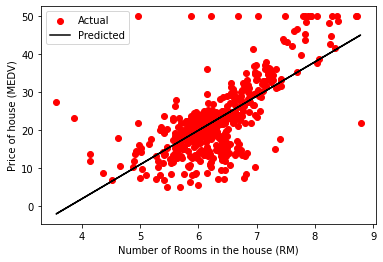

Iteration: 89000, Cost = 21.801895819116808, Weights = [-34.15782448   9.0214948 ]


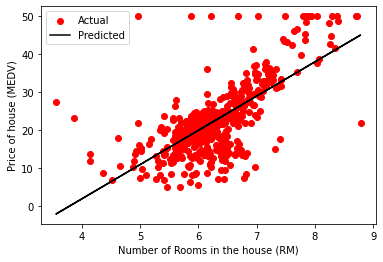

Iteration: 90000, Cost = 21.80174893477965, Weights = [-34.18162522   9.0252364 ]


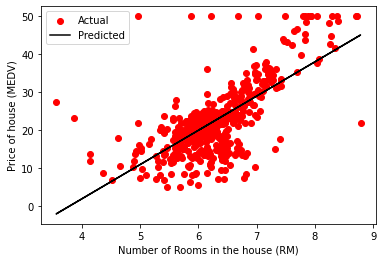

Iteration: 91000, Cost = 21.801615368895405, Weights = [-34.20432129   9.02880434]


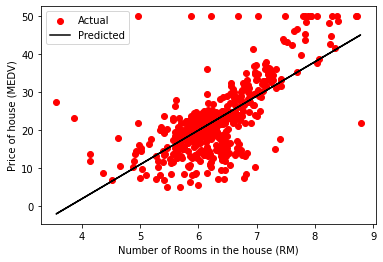

Iteration: 92000, Cost = 21.801493913839177, Weights = [-34.22596395   9.03220667]


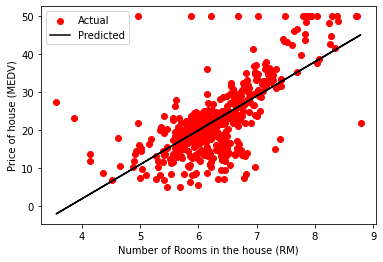

Iteration: 93000, Cost = 21.801383471485046, Weights = [-34.24660209   9.03545109]


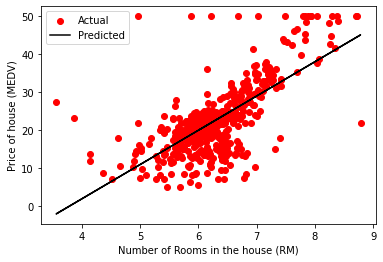

Iteration: 94000, Cost = 21.801283043277596, Weights = [-34.26628234   9.03854493]


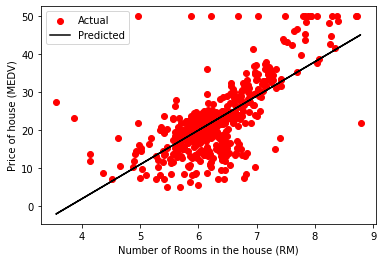

Iteration: 95000, Cost = 21.801191721203452, Weights = [-34.28504917   9.04149517]


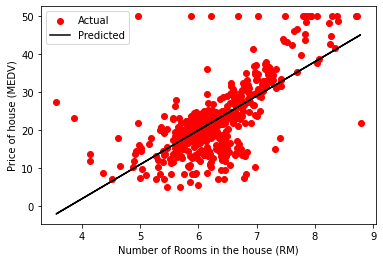

Iteration: 96000, Cost = 21.801108679581606, Weights = [-34.30294495   9.04430848]


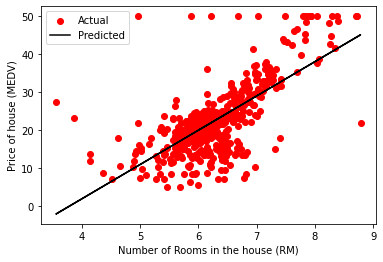

Iteration: 97000, Cost = 21.801033167598064, Weights = [-34.32001012   9.04699121]


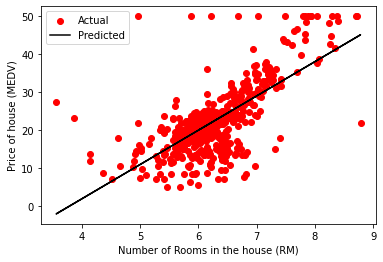

Iteration: 98000, Cost = 21.800964502517438, Weights = [-34.33628324   9.04954943]


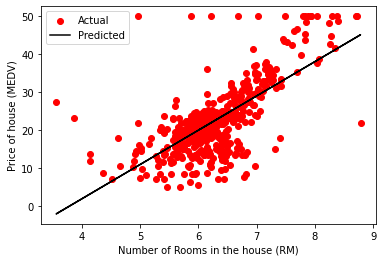

Iteration: 99000, Cost = 21.80090206351008, Weights = [-34.35180107   9.05198891]


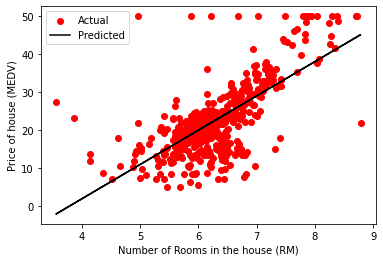

Iteration: 100000, Cost = 21.800845286038836, Weights = [-34.36659865   9.05431516]


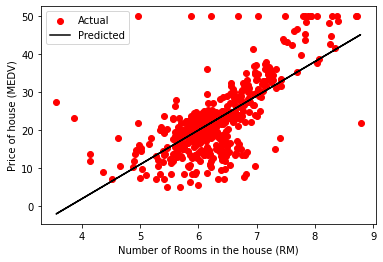

Iteration: 101000, Cost = 21.800793656754905, Weights = [-34.38070943   9.05653345]


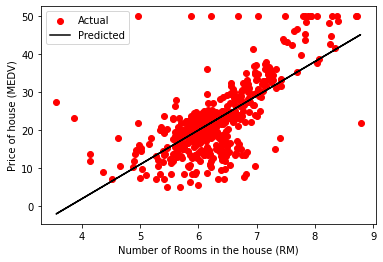

Iteration: 102000, Cost = 21.80074670885636, Weights = [-34.39416527   9.05864877]


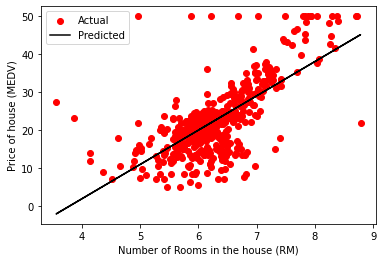

Iteration: 103000, Cost = 21.800704017867634, Weights = [-34.40699658   9.06066592]


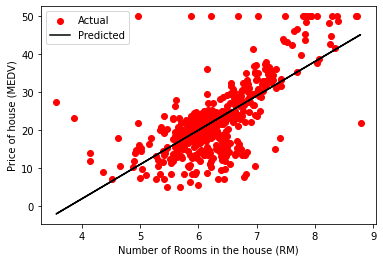

Iteration: 104000, Cost = 21.800665197801642, Weights = [-34.41923234   9.06258944]


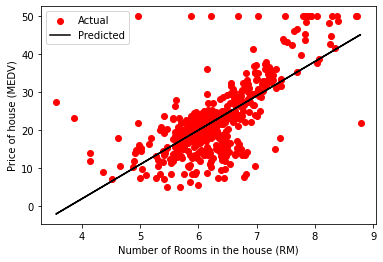

Iteration: 105000, Cost = 21.80062989766998, Weights = [-34.43090019   9.06442369]


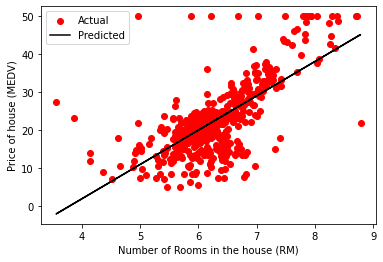

Iteration: 106000, Cost = 21.80059779830949, Weights = [-34.4420265   9.0661728]


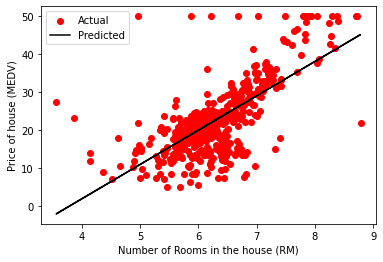

Iteration: 107000, Cost = 21.800568609496302, Weights = [-34.45263639   9.06784073]


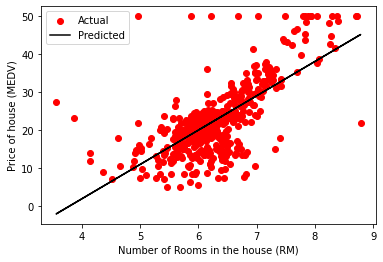

Iteration: 108000, Cost = 21.800542067322286, Weights = [-34.46275384   9.06943125]


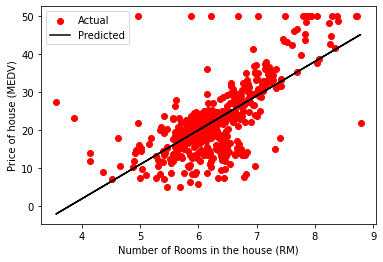

Iteration: 109000, Cost = 21.80051793180853, Weights = [-34.4724017    9.07094794]


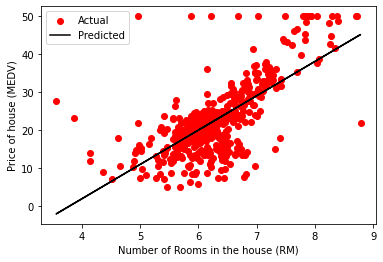

Iteration: 110000, Cost = 21.800495984735726, Weights = [-34.48160177   9.07239424]


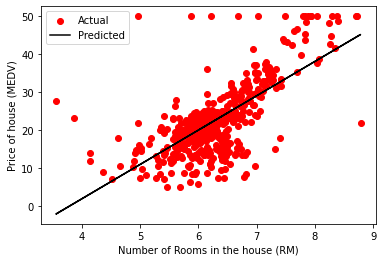

Iteration: 111000, Cost = 21.800476027671284, Weights = [-34.49037483   9.07377341]


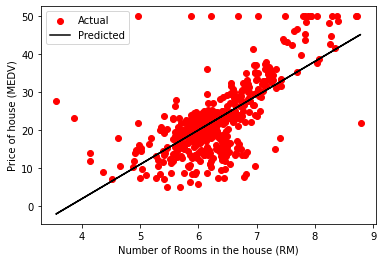

Iteration: 112000, Cost = 21.800457880175042, Weights = [-34.49874071   9.07508856]


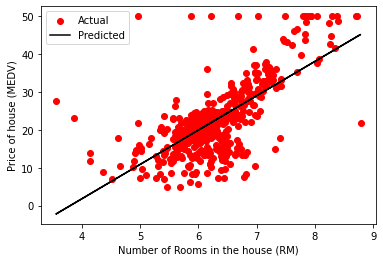

Iteration: 113000, Cost = 21.80044137816787, Weights = [-34.50671829   9.07634268]


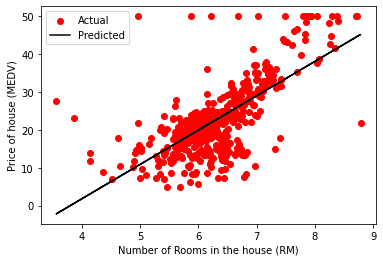

Iteration: 114000, Cost = 21.800426372448243, Weights = [-34.5143256    9.07753859]


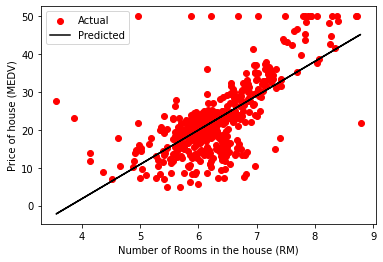

Iteration: 115000, Cost = 21.80041272734321, Weights = [-34.52157983   9.07867899]


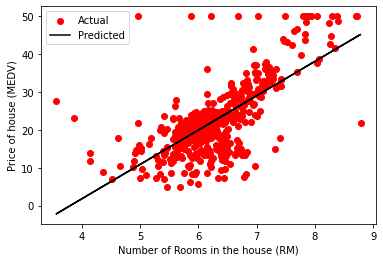

Iteration: 116000, Cost = 21.80040031948164, Weights = [-34.52849736   9.07976646]


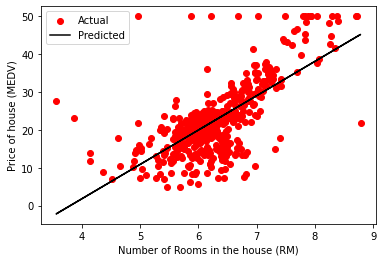

Iteration: 117000, Cost = 21.800389036678947, Weights = [-34.53509383   9.08080346]


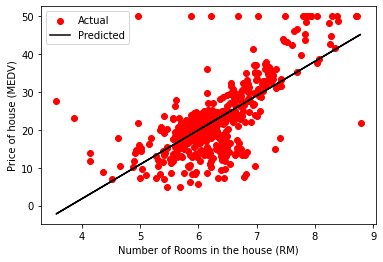

Iteration: 118000, Cost = 21.800378776922503, Weights = [-34.54138413   9.08179232]


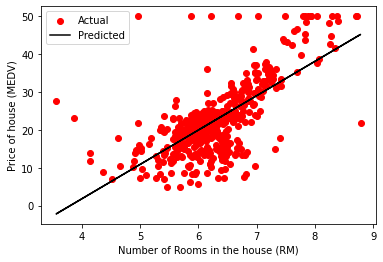

Iteration: 119000, Cost = 21.80036944744963, Weights = [-34.54738247   9.08273529]


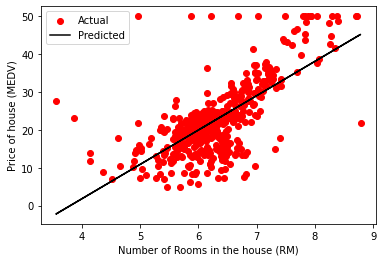

Iteration: 120000, Cost = 21.800360963908656, Weights = [-34.55310241   9.0836345 ]


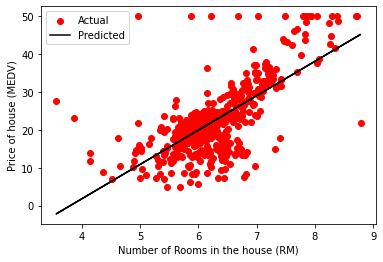

Iteration: 121000, Cost = 21.800353249596345, Weights = [-34.55855687   9.08449197]


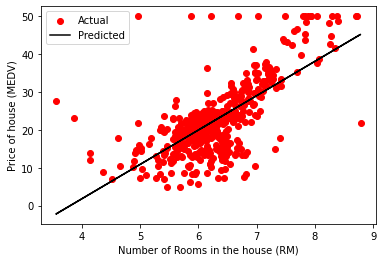

Iteration: 122000, Cost = 21.800346234764348, Weights = [-34.56375816   9.08530964]


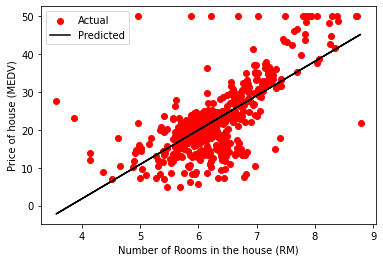

Iteration: 123000, Cost = 21.800339855988664, Weights = [-34.56871804   9.08608935]


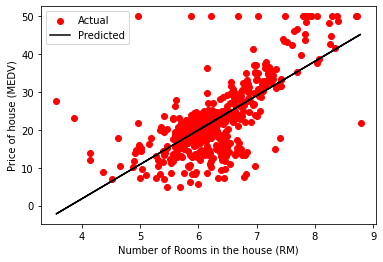

Iteration: 124000, Cost = 21.80033405559613, Weights = [-34.57344772   9.08683288]


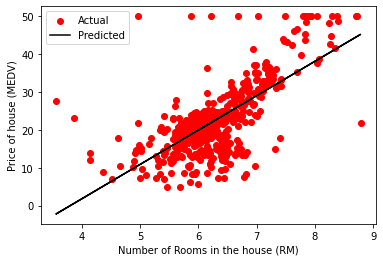

Iteration: 125000, Cost = 21.80032878114295, Weights = [-34.57795788   9.0875419 ]


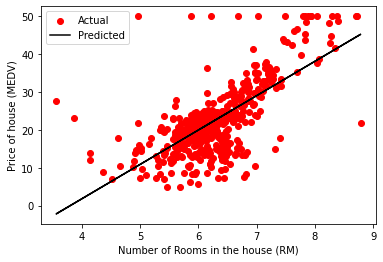

Iteration: 126000, Cost = 21.800323984940583, Weights = [-34.5822587    9.08821801]


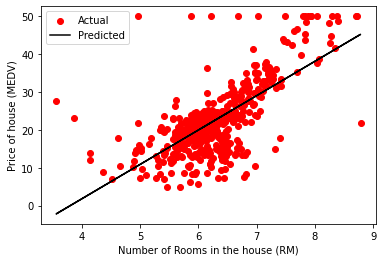

Iteration: 127000, Cost = 21.800319623624627, Weights = [-34.58635991   9.08886275]


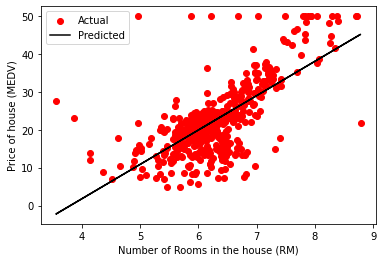

Iteration: 128000, Cost = 21.800315657762532, Weights = [-34.59027076   9.08947755]


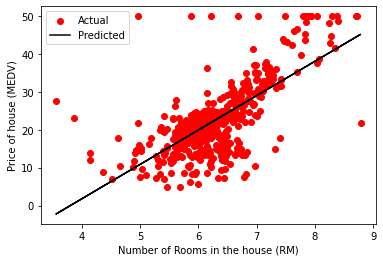

Iteration: 129000, Cost = 21.800312051497308, Weights = [-34.5940001    9.09006382]


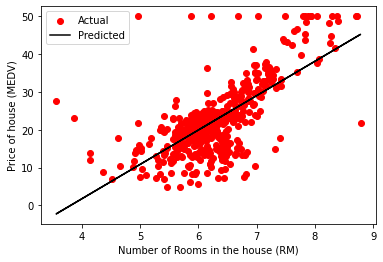

Iteration: 130000, Cost = 21.800308772223207, Weights = [-34.59755634   9.09062288]


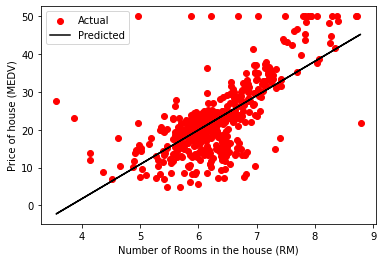

Iteration: 131000, Cost = 21.800305790290942, Weights = [-34.60094753   9.09115599]


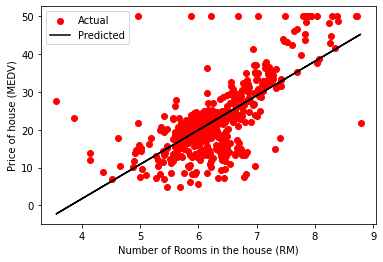

Iteration: 132000, Cost = 21.800303078739624, Weights = [-34.60418132   9.09166436]


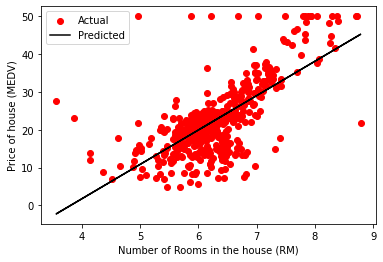

Iteration: 133000, Cost = 21.800300613052926, Weights = [-34.60726502   9.09214913]


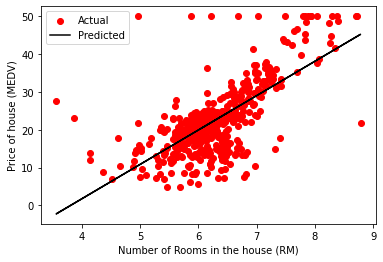

Iteration: 134000, Cost = 21.800298370937607, Weights = [-34.61020559   9.09261141]


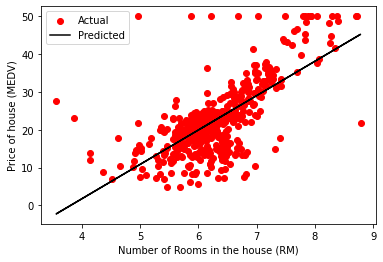

Iteration: 135000, Cost = 21.80029633212176, Weights = [-34.61300968   9.09305222]


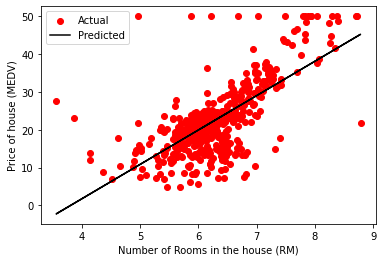

Iteration: 136000, Cost = 21.800294478171608, Weights = [-34.61568362   9.09347258]


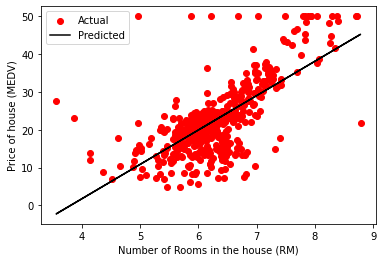

Iteration: 137000, Cost = 21.800292792324797, Weights = [-34.61823345   9.09387343]


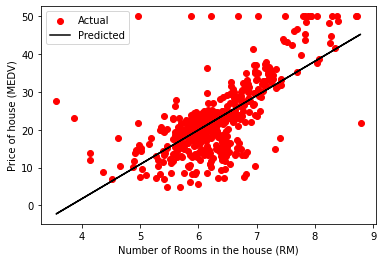

Iteration: 138000, Cost = 21.80029125933885, Weights = [-34.62066494   9.09425567]


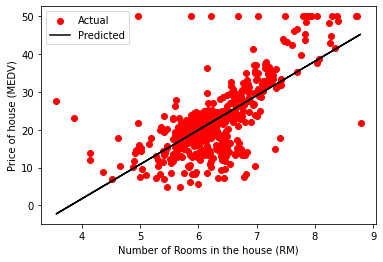

Iteration: 139000, Cost = 21.80028986535347, Weights = [-34.62298357   9.09462017]


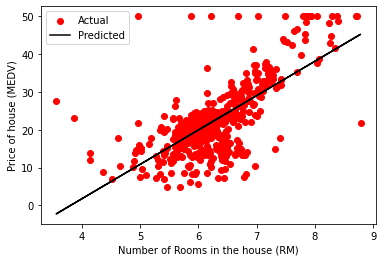

Iteration: 140000, Cost = 21.800288597764993, Weights = [-34.62519459   9.09496775]


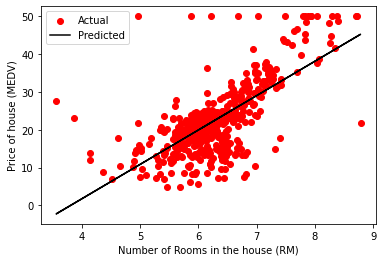

Iteration: 141000, Cost = 21.800287445112662, Weights = [-34.62730298   9.0952992 ]


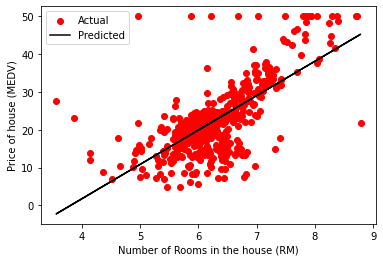

Iteration: 142000, Cost = 21.800286396974876, Weights = [-34.62931352   9.09561527]


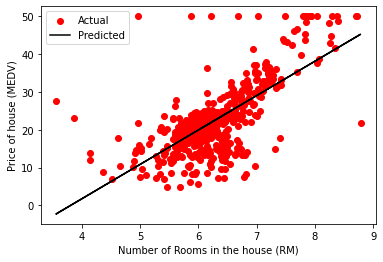

Iteration: 143000, Cost = 21.80028544387492, Weights = [-34.63123074   9.09591667]


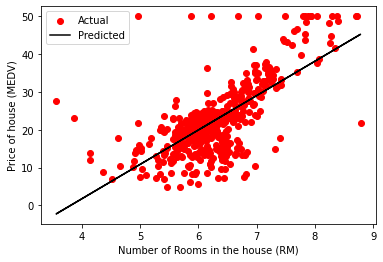

Iteration: 144000, Cost = 21.80028457719546, Weights = [-34.63305897   9.09620408]


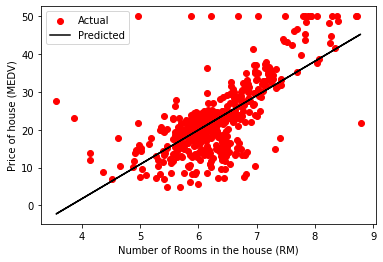

Iteration: 145000, Cost = 21.8002837891005, Weights = [-34.63480235   9.09647814]


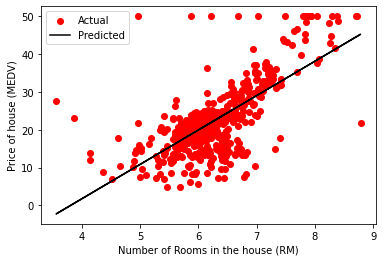

Iteration: 146000, Cost = 21.8002830724645, Weights = [-34.63646482   9.09673949]


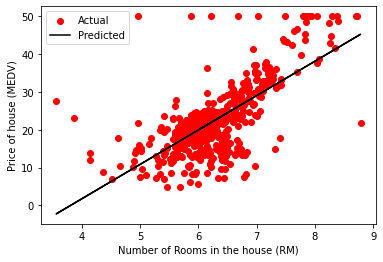

Iteration: 147000, Cost = 21.8002824208081, Weights = [-34.63805012   9.09698871]


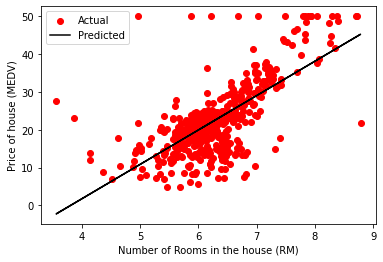

Iteration: 148000, Cost = 21.800281828239363, Weights = [-34.63956184   9.09722636]


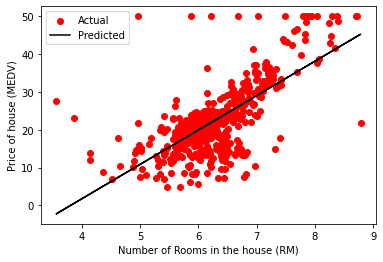

Iteration: 149000, Cost = 21.80028128940068, Weights = [-34.6410034    9.09745298]


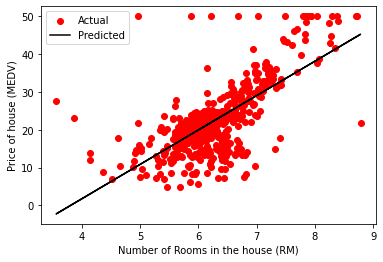

Iteration: 150000, Cost = 21.800280799887197, Weights = [-34.64237671   9.09766887]


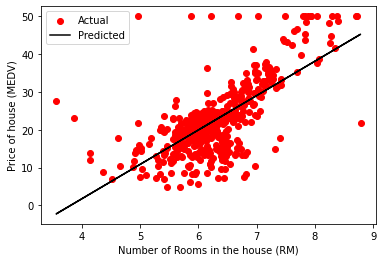

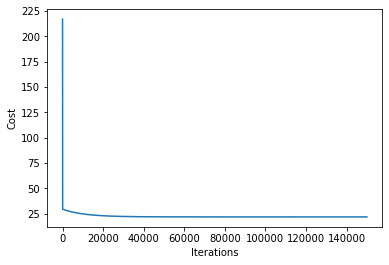

In [ ]:
# call tha fit function and display the results
n_iter=150000
x = boston_data["RM"]
X = np.column_stack((np.ones(len(x)),x))
Y = boston_data["MEDV"]
fit(n_iter,X,Y)

# Coursework:

## Task 1:

- As you noticed, GD approach was used for optimisation. Use the closed form solution (from week 1) in solving the previous problem. In your report:

     -  Include the code you used for the closed form.

     - Compare the final weights you achived from the GD with your results in closed form solution and include that in your report. 
     
     - Include the plot showing the line produced from the closed form solution with respect to the original data as in the previous example.
     
     - Hint: have a look on the following function numpy.linalg.pinv on Numpy that can compute the (Moore-Penrose) pseudo-inverse of a matrix

- Modify the code to predict the price of house (MEDV) vs NOX concentration  and price of house (MEDV) vs % lower status of the population (LSTAT) and do the same steps as before.

## Task 2:

- Rewrite the code using scikit-learn package for MEDV vs each feature used previousely (RM, NOX, LSTAT) (More information can be found here: https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LinearRegression.html). In your report:

    - Include the code you used.
    - Compare the final weights obtained in Task 1 with what weights obtained using scikit-learn package. Hint: check the methods $.coef_$ and $.intercept_$ for obtaining the slope and intercept in scikit-learn linear regressor.